In [1]:
%matplotlib inline
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import math

In [2]:
def fetch(url):
    import requests, gzip, os, hashlib

    cache_dir = os.path.join(os.getcwd(), ".cache")
    if not os.path.isdir(cache_dir):
        os.mkdir(cache_dir)

    fp = os.path.join(cache_dir, hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return np.frombuffer(gzip.decompress(dat), dtype=np.uint8)

X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[16:].reshape((-1, 28, 28)).astype(np.float32) / 255
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[16:].reshape((-1, 28, 28)).astype(np.float32) / 255
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import tensor

class SmolNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(28 * 28, 128, bias=False)
        self.l2 = nn.Linear(128, 10, bias=False)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.log_softmax(self.l2(x), dim=1)
        return x


loss=0.78, acc=0.906250: 100%|██████████| 1000/1000 [00:01<00:00, 507.70it/s]


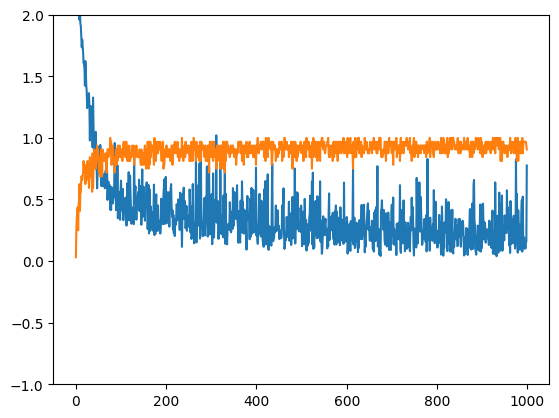

In [4]:
def torch_train(model):
    BATCH = 32
    loss_func = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters())
    accuracies = []
    losses = []
    for i in (t := trange(1000)):
        # prepare data
        samp = np.random.randint(0, X_train.shape[0], size=(BATCH))
        X = tensor(X_train[samp], requires_grad=True).reshape((-1, 28*28))
        Y = tensor(Y_train[samp]).long()

        # train
        optimizer.zero_grad()
        out = model(X)
        pred = out.argmax(axis=1)
        acc = (pred == Y).float().mean()
        loss = F.nll_loss(out, Y)
        loss.backward()
        optimizer.step()

        # stat
        acc, loss = acc.item(), loss.item()
        accuracies.append(acc)
        losses.append(loss)
        t.set_description('loss={:.2f}, acc={:2f}'.format(loss, acc))

    return losses, accuracies

model = SmolNet()
losses, accuracies = torch_train(model)
plt.ylim(-1, 2)
plt.plot(losses)
plt.plot(accuracies)

In [5]:
def torch_eval():
    X = tensor(X_test).reshape((-1, 28*28))
    Y = tensor(Y_test)
    out = model(X)
    pred = out.argmax(axis=1)
    acc = (Y == pred).float().mean()
    return acc

torch_eval()

tensor(0.9406)

In [6]:
# copy model from pytorch to numpy
l1 = np.zeros((28*28, 128), dtype=np.float32)
l2 = np.zeros((128, 10), dtype=np.float32)
l1[:] = model.l1.weight.detach().numpy().transpose()
l2[:] = model.l2.weight.detach().numpy().transpose()

In [7]:
# smolgrad forward
def forward(x):
    x = x.dot(l1)
    x = np.maximum(0, x) # relu
    x = x.dot(l2)

    # log softmax
    den = np.log(np.exp(x).sum())
    x = np.log(np.exp(x)) - den

    return x

In [8]:
# now we have the same weights in numpy arrays
# we can test whether our forward pass works by checking on the accuarcy

def smol_eval():
    preds = forward(X_test.reshape((-1, 28*28))).argmax(axis=1)
    acc = (preds == Y_test).mean()
    return acc

smol_acc = smol_eval()
torch_acc = torch_eval().item()

if math.isclose(torch_acc, smol_acc, abs_tol=1e-4):
    print('accuracy matches!')

smol_acc, torch_acc

accuracy matches!


(0.9406, 0.9405999779701233)

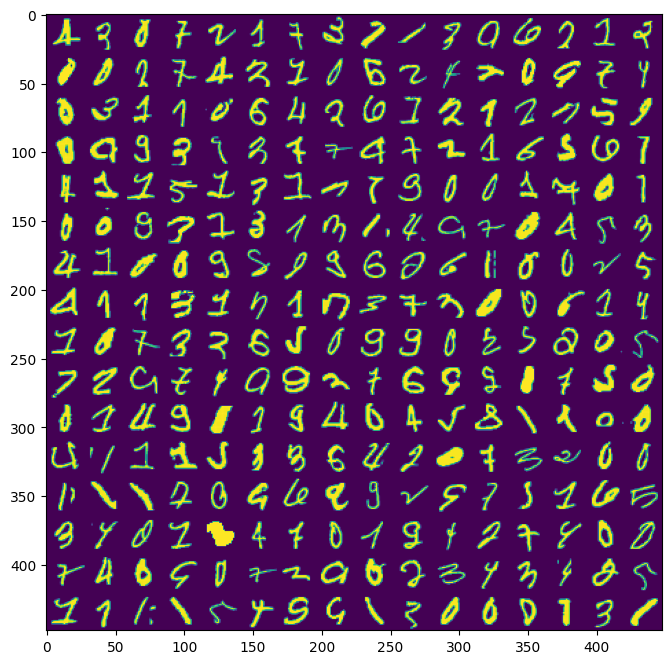

In [9]:
def smol_loss(X, Y):
    X = X.reshape((-1, 28*28))
    out = forward(X)
    pred = out.argmax(axis=1)
    loss = -out[range(out.shape[0]), Y]

    return loss

def show_cursed_digits(X, loss):
    G = 16
    messup = sorted(zip(loss, range(X.shape[0])), key=lambda x: x[0], reverse=True)
    X_bad = X[[x[1] for x in messup[:G*G]]]
    plt.figure(figsize=(8,8))
    imshow(np.concatenate(X_bad.reshape((G, 28 * G, 28)), axis=1))

show_cursed_digits(X_train, smol_loss(X_train, Y_train))

tensor(0.2662, grad_fn=<NllLossBackward0>)
loss.grad = tensor(1.)
x_lsm.grad = tensor([[ 0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.]])
x_l2.grad = tensor([[ 5.7958e-05,  8.9008e-06,  2.8127e-04,  2.3213e-01,  4.3179e-08,
         -2.3373e-01,  4.3636e-06,  6.3053e-04,  1.9554e-04,  4.2227e-04]])


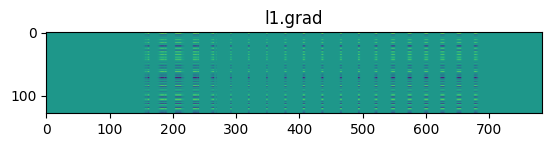

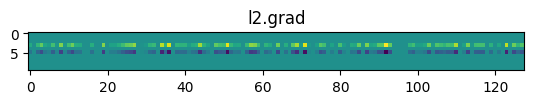

In [19]:
# backward, pytorch reference
def torch_backward():
    model.zero_grad()

    # forward
    x = tensor(X_train[0:1].reshape((-1, 28*28)))
    x_l1 = model.l1(x)
    x_relu = F.relu(x_l1)
    x_l2 = model.l2(x_relu)
    x_lsm = F.log_softmax(x_l2, dim=1)
    loss = F.nll_loss(x_lsm, tensor(Y_train[0:1]))
    print(loss)

    x_l1.retain_grad()
    x_relu.retain_grad()
    x_l2.retain_grad()
    x_lsm.retain_grad()
    loss.retain_grad()

    # backward
    loss.backward()

    print('loss.grad =', loss.grad)
    print('x_lsm.grad =', x_lsm.grad)
    print('x_l2.grad =', x_l2.grad)
    #print('x_relu.grad =', x_relu.grad)
    #print('x_l1.grad =', x_l1.grad)

    plt.figure()
    plt.title("l1.grad")
    imshow(model.l1.weight.grad)

    plt.figure()
    plt.title("l2.grad")
    imshow(model.l2.weight.grad)

torch_backward()

[[ 5.79578518e-05  8.90077172e-06  2.81274377e-04  2.32126445e-01
   4.31789609e-08 -2.33727336e-01  4.36357732e-06  6.30530587e-04
   1.95540051e-04  4.22273879e-04]]


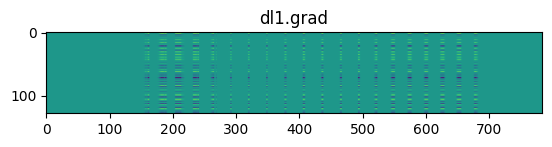

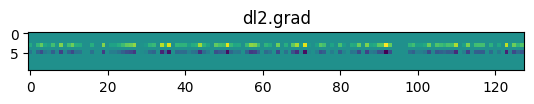

In [22]:
# backward, ours
def smol_backward():

    # forward
    X = X_train[0:1]
    x = X.reshape((-1, 28*28))
    x_l1 = x.dot(l1)
    x_relu = np.maximum(0, x_l1)
    x_l2 = x_relu.dot(l2) # W = trelu, x = l2, feels inverted...
    x_lsm = x_l2 - np.log(np.exp(x_l2).sum()) # log softmax
    loss = -x_lsm[range(x_lsm.shape[0]), Y_train[0:1]] # nll, take label component and neagte

    # backward

    # gradient of NLL, i.e. dL/dout
    dlsm = np.zeros(x_lsm.shape)
    dlsm[range(dlsm.shape[0]), Y_train[0:1]] = -1.0

    # gradient of log softmax, i.e. dL/dxl2
    dx_l2 = dlsm - np.exp(x_lsm)*dlsm.sum()

    # gradient of dot(l2), dL/drelu and dL/dl2
    # input dtl2 (1,10), trelu (1, 128)
    # output (128, 10)
    dl2 = x_relu.T.dot(dx_l2)

    # input dtl2 (1, 10), l2 (128,10)
    # output shape (1, 128)
    dx_relu = dx_l2.dot(l2.T)

    # gradient of relu, dL/dtl1 = dL/drelu * drelu/dtl1
    dx_l1 = dx_relu.copy()
    dx_l1[(x_l1 < 0.0)] = 0.0

    # gradient of dot(l1), dL/dx or dL/dl1, but we only want dL/dl1, because we already reached the starting point
    # dL/dl1 = dL/dtl1 * dtl1/dl1 = dL/dtl1 * x
    # input x (1,784), dtl1 (1, 128)
    # output (784, 128)
    dl1 = x.T.dot(dx_l1)

    plt.figure()
    plt.title("dl1.grad")
    imshow(dl1.T)
    plt.figure()
    plt.title("dl2.grad")
    imshow(dl2.T)
    print(dx_l2)

smol_backward()
    